# Test for `bond_mat_2_dist_mat`

This notebook builds a small synthetic example to verify that:

- the atomic adjacency graph is built on **3L** backbone atoms (`N, CA, C` per residue), and
- the residue-level diffusion distance matrix has shape **(L, L, features)** after averaging over the 3×3 atomic blocks for each residue pair.

We also sanity-check the degrees and intra-residue edges for a few residues.


In [ ]:
import torch
from types import SimpleNamespace

from BondFlow.models.mymodel import MySampler

# Helper: build a lightweight MySampler instance without running __init__
# so we don't need a full training/inference config or model weights.
def build_dummy_sampler(device="cpu"):
    sampler = MySampler.__new__(MySampler)
    sampler.device = torch.device(device)

    # Minimal config needed by bond_mat_2_dist_mat -> diffusion_distance_tensor
    preprocess_cfg = SimpleNamespace(
        diffusion_map_times=[0.1, 1.0],
        diffusion_map_features=8,
    )
    sampler._conf = SimpleNamespace(preprocess=preprocess_cfg)
    return sampler


device = "cpu"
sampler = build_dummy_sampler(device=device)

# Simple toy example
# -------------------
# We create B=1, L=4 residues in a single chain.
B, L = 1, 4

# Bond matrix over residues (CA-CA level). For this smoke test we just use
# a simple pattern; diagonal will be ignored inside bond_mat_2_dist_mat.
bond_mat = torch.zeros(B, L, L, dtype=torch.float32, device=device)
# Add one CA-CA bond between residue 1 and 2 for demonstration
bond_mat[0, 1, 2] = 1.0
bond_mat[0, 2, 1] = 1.0

# rf_idx encodes residue indices used to detect chain breaks
# Here we simulate a single continuous chain: 0,1,2,3
rf_idx = torch.arange(L, dtype=torch.long, device=device).unsqueeze(0)

# All residues are valid in this toy example
res_mask = torch.ones(B, L, dtype=torch.bool, device=device)

# Head/tail masks: mark residue 0 as N-terminus and residue 3 as C-terminus
head_mask = torch.zeros(B, L, dtype=torch.bool, device=device)
tail_mask = torch.zeros(B, L, dtype=torch.bool, device=device)
head_mask[0, 0] = True
tail_mask[0, 3] = True

# N_C_anchor: in this synthetic example we don't need real anchors for
# the atomic graph, so we just pass an all-zero tensor of shape (B, L, L, 2)
N_C_anchor = torch.zeros(B, L, L, 2, dtype=torch.bool, device=device)

# Run bond_mat_2_dist_mat with atomic-graph path enabled
# res_dist_matrix, meta = sampler.bond_mat_2_dist_mat(
#     bond_mat=bond_mat,
#     rf_idx=rf_idx,
#     res_mask=res_mask,
#     head_mask=head_mask,
#     tail_mask=tail_mask,
#     N_C_anchor=N_C_anchor,
# )

print("res_dist_matrix.shape:", res_dist_matrix.shape)
print("expected batch, nodes:", (B, L, L))

# Optionally, inspect feature dimension (T * rbf_num)
print("feature_dim (last axis):", res_dist_matrix.shape[-1])


/home/fit/lulei/WORK/.conda/envs/apm_env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
/home/fit/lulei/WORK/.conda/envs/apm_env/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:70: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):


AttributeError: 'MySampler' object has no attribute 'bond_mat_2_dist_mat'

In [ ]:
import BondFlow.data.SM_utlis as smu
from typing import Optional, Tuple
def _build_res_dist_embed(
    bond_mat: torch.Tensor,
    rf_idx: torch.Tensor,
    res_mask: torch.Tensor,
    head_mask: Optional[torch.Tensor] = None,
    tail_mask: Optional[torch.Tensor] = None,
    N_C_anchor: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    Build pairwise diffusion-distance embedding from a bond matrix using
    an atomic (3L-node) graph and a lightweight ScoreNet over the 3x3
    backbone-atom patch per residue pair.

    Pipeline (per batch):
        1. Construct atomic adjacency A_atom over nodes {N_i, CA_i, C_i} for i=0..L-1.
        2. Run diffusion_distance_tensor on A_atom -> X: [B, 3L, 3L, D1].
        3. Reshape X -> [B, L, L, 3, 3, D1].
        4. Apply shared Linear(D1 -> d') on the last dim.
        5. ScoreNet MLP(d' -> 1) produces 3x3 token scores, softmax over 9 tokens.
        6. Weighted sum over 9 tokens -> [B, L, L, d'].
        7. Final MLP(d' -> pair_embed_size) -> res_dist_embed: [B, L, L, pair_embed_size].
    """
    B, L_total = bond_mat.shape[:2]

    use_atomic_graph = (
        head_mask is not None
        and tail_mask is not None
        and N_C_anchor is not None
    )

    # -----------------------------
    # Fallback: original behaviour (residue graph)
    # -----------------------------
    if not use_atomic_graph:
        # 此处保留原有的 Fallback 逻辑，为了代码简洁省略具体实现
        # 如果需要完整运行，请确保这里调用了原本的逻辑
        return self._bond_mat_2_dist_mat_fallback(bond_mat, rf_idx, res_mask, time_embedding)

    # ---------------------------------------
    # Upgraded: Atomic Graph (Vectorized & Weighted)
    # ---------------------------------------
    device = bond_mat.device
    dtype = bond_mat.dtype

    head_mask = head_mask.bool()
    tail_mask = tail_mask.bool()
    res_mask_bool = res_mask.bool().squeeze(-1) if res_mask.dim() == 3 else res_mask.bool()

    # 1. Prepare Body Mask & Counts
    body_mask_bool = res_mask_bool & (~head_mask) & (~tail_mask)
    body_counts = body_mask_bool.sum(dim=1)
    
    # Handle degenerate case
    if int(body_counts.max().item()) == 0:
        return self.bond_mat_2_dist_mat(bond_mat, rf_idx, res_mask, bond_mask, time_embedding)

    L_body_max = int(body_counts.max().item())
    N_atom = 3 * L_body_max

    # --- 2. Vectorized Owner Mapping ---
    # Initialize owner as self (0..L-1)
    owner_global = torch.arange(L_total, device=device).view(1, L_total).expand(B, L_total).clone()
    
    # Precompute body local indices [B, L_total] -> 0..Lb or -1
    body_cumsum = body_mask_bool.long().cumsum(dim=1)
    body_local_all = body_cumsum - 1
    body_local_all = body_local_all.masked_fill(~body_mask_bool, -1)

    # Function to update owners based on anchors (Vectorized)
    def _assign_owner_vectorized(layer_idx, func_mask):
        if not func_mask.any(): return
        # anchor_layer: [B, L_func, L_anchor]
        anchor_layer = N_C_anchor[..., layer_idx]
        # Mask out invalid body columns
        valid_anchor_cols = body_mask_bool.unsqueeze(1) 
        masked_anchors = anchor_layer & valid_anchor_cols
        
        anchor_exists = masked_anchors.any(dim=2) 
        anchor_idx = masked_anchors.float().argmax(dim=2) 
        
        update_mask = func_mask & anchor_exists
        owner_global[update_mask] = anchor_idx[update_mask]

    _assign_owner_vectorized(0, head_mask) # N-side
    _assign_owner_vectorized(1, tail_mask) # C-side

    # Atom types: 0->N, 1->CA, 2->C
    center_type = torch.full((B, L_total), 1, device=device, dtype=torch.long)
    center_type[head_mask] = 0
    center_type[tail_mask] = 2

    # --- 3. Build Weighted Atomic Adjacency ---
    A_atom = torch.zeros((B, N_atom, N_atom), device=device, dtype=dtype)
    
    # 3.1 Intra-residue edges (Weight = 1.0)
    # Create indices for valid atoms in batch
    seq_range = torch.arange(L_body_max, device=device).unsqueeze(0)
    len_mask = seq_range < body_counts.unsqueeze(1) # [B, Lb]
    atom_valid_mask = len_mask.repeat_interleave(3, dim=1) # [B, 3Lb]
    
    batch_idx_grid = torch.arange(B, device=device).unsqueeze(1).expand(B, L_body_max)
    b_ids = batch_idx_grid[len_mask]
    l_ids = seq_range.expand(B, L_body_max)[len_mask]
    
    n_ids = 3 * l_ids; ca_ids = n_ids + 1; c_ids = n_ids + 2
    
    b_intra = torch.cat([b_ids, b_ids, b_ids, b_ids])
    u_intra = torch.cat([n_ids, ca_ids, ca_ids, c_ids])
    v_intra = torch.cat([ca_ids, n_ids, c_ids, ca_ids])
    w_intra = torch.ones_like(b_intra, dtype=dtype) # Fixed strong connection

    # 3.2 Peptide bonds (Weight = 1.0)
    is_seq = (rf_idx[:, 1:] == rf_idx[:, :-1] + 1) & res_mask_bool[:, :-1] & res_mask_bool[:, 1:]
    seq_b, seq_i = torch.nonzero(is_seq, as_tuple=True)
    
    if seq_b.numel() > 0:
        owner_i = body_local_all[seq_b, seq_i]
        owner_ip1 = body_local_all[seq_b, seq_i + 1]
        valid_pep = (owner_i >= 0) & (owner_ip1 >= 0)
        
        seq_b = seq_b[valid_pep]
        owner_i = owner_i[valid_pep]
        owner_ip1 = owner_ip1[valid_pep]
        
        c_i = 3 * owner_i + 2
        n_ip1 = 3 * owner_ip1 + 0
        
        b_pep = torch.cat([seq_b, seq_b])
        u_pep = torch.cat([c_i, n_ip1])
        v_pep = torch.cat([n_ip1, c_i])
        w_pep = torch.ones_like(b_pep, dtype=dtype)
    else:
        b_pep = u_pep = v_pep = w_pep = torch.empty(0, device=device, dtype=dtype)

    # 3.3 Special bonds (Weighted from bond_mat)
    # Threshold changed from 0.5 to 0.01 to preserve weak signals
    threshold = 1e-4
    bm_mask = (bond_mat > threshold)
    bm_mask.diagonal(dim1=1, dim2=2).fill_(False)
    
    sp_b, sp_i, sp_j = torch.nonzero(bm_mask, as_tuple=True)
    
    if sp_b.numel() > 0:
        # [KEY CHANGE]: Extract actual weights instead of using 1.0
        edge_weights = bond_mat[sp_b, sp_i, sp_j]

        owner_i_g = owner_global[sp_b, sp_i]
        owner_j_g = owner_global[sp_b, sp_j]
        owner_i_l = body_local_all[sp_b, owner_i_g]
        owner_j_l = body_local_all[sp_b, owner_j_g]
        
        valid_sp = (owner_i_l >= 0) & (owner_j_l >= 0)
        
        sp_b = sp_b[valid_sp]
        edge_weights = edge_weights[valid_sp] # Filter weights too
        owner_i_l = owner_i_l[valid_sp]
        owner_j_l = owner_j_l[valid_sp]
        
        t_i = center_type[sp_b, sp_i[valid_sp]]
        t_j = center_type[sp_b, sp_j[valid_sp]]
        
        atom_i = 3 * owner_i_l + t_i
        atom_j = 3 * owner_j_l + t_j
        
        b_sp = torch.cat([sp_b, sp_b])
        u_sp = torch.cat([atom_i, atom_j])
        v_sp = torch.cat([atom_j, atom_i])
        w_sp = torch.cat([edge_weights, edge_weights]) # Symmetric weights
    else:
        b_sp = u_sp = v_sp = w_sp = torch.empty(0, device=device, dtype=dtype)

    # Combine & Fill
    b_all = torch.cat([b_intra, b_pep, b_sp])
    u_all = torch.cat([u_intra, u_pep, u_sp])
    v_all = torch.cat([v_intra, v_pep, v_sp])
    w_all = torch.cat([w_intra, w_pep, w_sp])
    
    # index_put_ handles duplicate indices (though unlikely here) by overwriting
    # (accumulate=False matches original logic)
    A_atom.index_put_((b_all, u_all, v_all), w_all, accumulate=False)

    # --- 4. Diffusion & ScoreNet ---
    res_dist_atom = smu.diffusion_distance_tensor(
        A_adj_batch=A_atom,
        times=[1,2,3,4],
        k=240,
        skip_top=True,
        node_mask=atom_valid_mask.int(),
        rbf_num=100,
        rbf_gamma=None,
        k_ratio=0.7,
    )
    meta = {"atom_adj":A_atom}
    return res_dist_atom,meta

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize atomic adjacency for the first (and only) sample using meta from bond_mat_2_dist_mat
atom_adj = meta["atom_adj"][0].cpu().numpy()   # (3L, 3L)
L_atom = atom_adj.shape[0]
print("atom_adj shape", atom_adj.shape)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(atom_adj, cmap="Blues", vmin=0, vmax=1)
plt.colorbar(im, ax=ax, label="Connection")
ax.set_title(f"Atomic adjacency (size={L_atom}x{L_atom})")
plt.show()


NameError: name 'meta' is not defined

In [9]:
# Case 2: L=12 single-chain example

# We now test a longer single-chain example with L=12 residues.
B2, L2 = 1, 12

device = sampler.device

bond_mat2 = torch.zeros(B2, L2, L2, dtype=torch.float32, device=device)
# Add a few CA-CA bonds for demonstration
bond_mat2[0, 2, 5] = 1.0
bond_mat2[0, 5, 2] = 1.0
bond_mat2[0, 7, 10] = 1.0
bond_mat2[0, 10, 7] = 1.0
bond_mat2[0, 0, 9] = 1.0
bond_mat2[0, 9,0] = 1.0

# Single continuous chain: rf_idx = 0..11
rf_idx2 = torch.arange(L2, dtype=torch.long, device=device).unsqueeze(0)

res_mask2 = torch.ones(B2, L2, dtype=torch.bool, device=device)

head_mask2 = torch.zeros(B2, L2, dtype=torch.bool, device=device)
tail_mask2 = torch.zeros(B2, L2, dtype=torch.bool, device=device)
head_mask2[0, 0] = True
tail_mask2[0, L2 - 1] = True

# Minimal N_C_anchor: each functional node anchors to its own residue index
N_C_anchor2 = torch.zeros(B2, L2, L2, 2, dtype=torch.bool, device=device)
N_C_anchor2[0,0,1,0] = True
N_C_anchor2[0,1,0,0] = True

N_C_anchor2[0,-2,-1,1] = True
N_C_anchor2[0,-1,-2,1] = True

# for i in range(L2):
#     if head_mask2[0, i]:
#         N_C_anchor2[0, i, i, 0] = True
#     if tail_mask2[0, i]:
#         N_C_anchor2[0, i, i, 1] = True

res_dist_12, meta_12 = _build_res_dist_embed( #sampler.bond_mat_2_dist_mat(
    bond_mat=bond_mat2,
    rf_idx=rf_idx2,
    res_mask=res_mask2,
    head_mask=head_mask2,
    tail_mask=tail_mask2,
    N_C_anchor=N_C_anchor2,
)

print("[L=12] res_dist_12.shape:", res_dist_12.shape)
print("[L=12] expected batch, nodes:", (B2, L2, L2))
print("[L=12] feature_dim (last axis):", res_dist_12.shape[-1])

atom_adj_12 = meta_12["atom_adj"][0]
print("[L=12] atom_adj_12 shape:", atom_adj_12.shape)


[L=12] res_dist_12.shape: torch.Size([1, 36, 36, 400])
[L=12] expected batch, nodes: (1, 12, 12)
[L=12] feature_dim (last axis): 400
[L=12] atom_adj_12 shape: torch.Size([36, 36])


atom_adj_12中值为1且索引间隔大于1的索引对：
(3, 28)
(7, 16)
(16, 7)
(22, 31)
(28, 3)
(31, 22)
[L=12] atom_adj_12 shape: (36, 36)


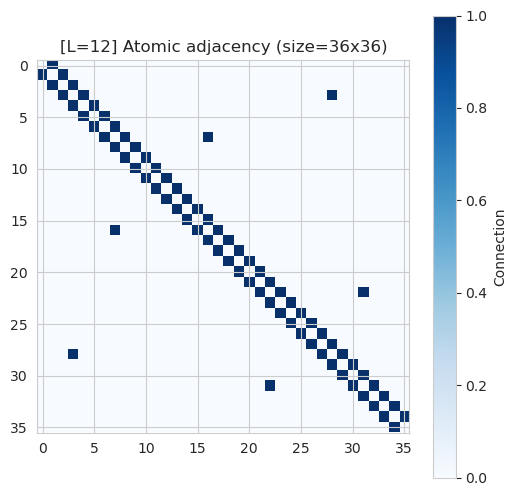

In [10]:
# Visualize atomic adjacency for L=12 case
import matplotlib.pyplot as plt
import numpy as np
# 打印atom_adj_12是1的索引，并且索引间隔大于1
# 假定atom_adj_12为tensor，需转换为numpy
ones_indices = np.argwhere(atom_adj_12.cpu().numpy() == 1)
# 只打印索引对(i,j)且abs(i-j)>1
filtered_indices = [tuple(idx) for idx in ones_indices if abs(idx[0] - idx[1]) > 1]
print("atom_adj_12中值为1且索引间隔大于1的索引对：")
for idx in filtered_indices:
    print(idx)

atom_adj_12_np = atom_adj_12.cpu().numpy()
L_atom_12 = atom_adj_12_np.shape[0]
print("[L=12] atom_adj_12 shape:", atom_adj_12_np.shape)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(atom_adj_12_np, cmap="Blues", vmin=0, vmax=1)
plt.colorbar(im, ax=ax, label="Connection")
ax.set_title(f"[L=12] Atomic adjacency (size={L_atom_12}x{L_atom_12})")
plt.show()


In [ ]:
# Case 3: L=20 double-chain example

# Two chains of length 10 each: residues 0-9 (chain A), 10-19 (chain B).
B3, L3 = 1, 20

bond_mat3 = torch.zeros(B3, L3, L3, dtype=torch.float32, device=device)
# Within chain A: add a bond between residues 2 and 7
bond_mat3[0, 0, 16] = 1
bond_mat3[0, 16, 0] = 1
# Within chain B: add a bond between residues 12 and 17
bond_mat3[0, 12, 17] = 1.0
bond_mat3[0, 17, 12] = 1.0

# rf_idx encodes a chain break between residue 9 and 10.
rf_idx3 = torch.arange(L3, dtype=torch.long, device=device).unsqueeze(0)
rf_idx3[0, 10:] += 100  # large jump to indicate a new chain

res_mask3 = torch.ones(B3, L3, dtype=torch.bool, device=device)

head_mask3 = torch.zeros(B3, L3, dtype=torch.bool, device=device)
tail_mask3 = torch.zeros(B3, L3, dtype=torch.bool, device=device)
# Chain A N/C
head_mask3[0, 0] = True
tail_mask3[0, 9] = True
# Chain B N/C
head_mask3[0, 10] = True
tail_mask3[0, 19] = True

N_C_anchor3 = torch.zeros(B3, L3, L3, 2, dtype=torch.bool, device=device)
N_C_anchor3[0,0,4,0] = True
N_C_anchor3[0,4,0,0] = True

N_C_anchor3[0,-2,-1,1] = True
N_C_anchor3[0,-1,-2,1] = True
# for i in range(L3):
#     if head_mask3[0, i]:
#         N_C_anchor3[0, i, i, 0] = True
#     if tail_mask3[0, i]:
#         N_C_anchor3[0, i, i, 1] = True

res_dist_20, meta_20 = sampler.bond_mat_2_dist_mat(
    bond_mat=bond_mat3,
    rf_idx=rf_idx3,
    res_mask=res_mask3,
    head_mask=head_mask3,
    tail_mask=tail_mask3,
    N_C_anchor=N_C_anchor3,
)

print("[L=20 double-chain] res_dist_20.shape:", res_dist_20.shape)
print("[L=20 double-chain] expected batch, nodes:", (B3, L3, L3))
print("[L=20 double-chain] feature_dim (last axis):", res_dist_20.shape[-1])

atom_adj_20 = meta_20["atom_adj"][0]
print("[L=20 double-chain] atom_adj_20 shape:", atom_adj_20.shape)

# Sanity check: there should be NO peptide edge between residue 9 (C) and 10 (N)
C9 = 3 * 9 + 2
N10 = 3 * 10 + 0
print("C9-N10 peptide edge (should be 0):", atom_adj_20[C9, N10].item())



[L=20 double-chain] res_dist_20.shape: torch.Size([1, 20, 20, 200])
[L=20 double-chain] expected batch, nodes: (1, 20, 20)
[L=20 double-chain] feature_dim (last axis): 200
[L=20 double-chain] atom_adj_20 shape: torch.Size([48, 48])
C9-N10 peptide edge (should be 0): 1.0


[L=20 double-chain] atom_adj_20 shape: (48, 48)


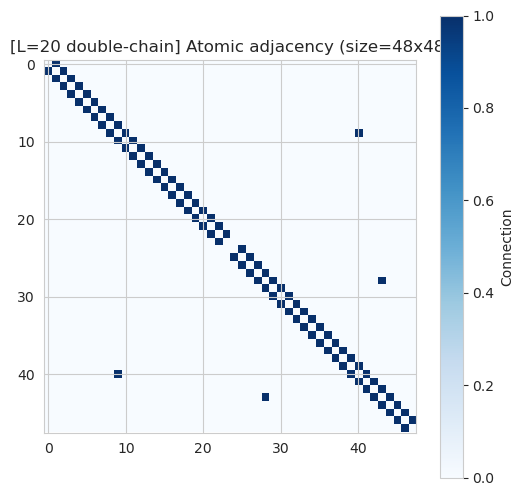

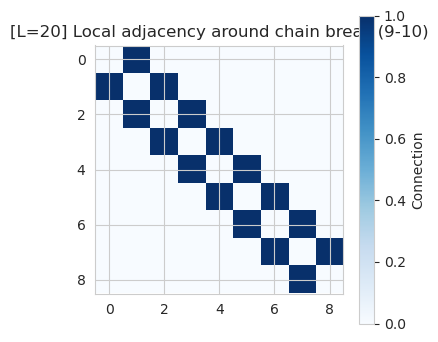

C9-N10 peptide edge (should be 0): 1.0


In [ ]:
# Visualize atomic adjacency for L=20 double-chain case
import matplotlib.pyplot as plt
import numpy as np

atom_adj_20_np = atom_adj_20.cpu().numpy()
L_atom_20 = atom_adj_20_np.shape[0]
print("[L=20 double-chain] atom_adj_20 shape:", atom_adj_20_np.shape)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(atom_adj_20_np, cmap="Blues", vmin=0, vmax=1)
plt.colorbar(im, ax=ax, label="Connection")
ax.set_title(f"[L=20 double-chain] Atomic adjacency (size={L_atom_20}x{L_atom_20})")
plt.show()

# Zoom-in on the peptide edge region around residues 9 and 10
C9 = 3 * 9 + 2
N10 = 3 * 10 + 0
window = slice(3*8, 3*11)  # a small window around the break
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(atom_adj_20_np[window, window], cmap="Blues", vmin=0, vmax=1)
plt.colorbar(im, ax=ax, label="Connection")
ax.set_title("[L=20] Local adjacency around chain break (9-10)")
plt.show()

print("C9-N10 peptide edge (should be 0):", atom_adj_20_np[C9, N10])


In [ ]:
# Case 4: L=20 double-chain example with res_mask

# 和 Case 3 一样，两条链各 10 个残基：0-9 (chain A), 10-19 (chain B)
B4, L4 = 1, 20
device = sampler.device

bond_mat4 = torch.zeros(B4, L4, L4, dtype=torch.float32, device=device)
# Chain A: 加一个 2–7 的 bond
bond_mat4[0, 2, 7] = 1.0
bond_mat4[0, 7, 2] = 1.0
# Chain B: 加一个 12–17 的 bond
bond_mat4[0, 12, 17] = 1.0
bond_mat4[0, 17, 12] = 1.0

# rf_idx4：在 9→10 之间制造 chain break
rf_idx4 = torch.arange(L4, dtype=torch.long, device=device).unsqueeze(0)
rf_idx4[0, 10:] += 100

# res_mask4：在两条链内部各 mask 掉两个残基
res_mask4 = torch.ones(B4, L4, dtype=torch.bool, device=device)
# chain A: mask 3,4
res_mask4[0, 3] = False
res_mask4[0, 4] = False
# chain B: mask 13,14
res_mask4[0, 13] = False
res_mask4[0, 14] = False

# head / tail 功能节点
head_mask4 = torch.zeros(B4, L4, dtype=torch.bool, device=device)
tail_mask4 = torch.zeros(B4, L4, dtype=torch.bool, device=device)
# Chain A N/C
head_mask4[0, 0] = True
tail_mask4[0, 9] = True
# Chain B N/C
head_mask4[0, 10] = True
tail_mask4[0, 19] = True

# N_C_anchor4：每个功能节点锚到自己那一残基
N_C_anchor4 = torch.zeros(B4, L4, L4, 2, dtype=torch.bool, device=device)
# Heads (N termini)
N_C_anchor4[0, 0, 0, 0] = True      # head at 0 -> res 0 (N)
N_C_anchor4[0, 10, 10, 0] = True   # head at 10 -> res 10 (N)
# Tails (C termini)
N_C_anchor4[0, 9, 9, 1] = True     # tail at 9 -> res 9 (C)
N_C_anchor4[0, 19, 19, 1] = True   # tail at 19 -> res 19 (C)

res_dist_20_masked, meta_20_masked = sampler.bond_mat_2_dist_mat(
    bond_mat=bond_mat4,
    rf_idx=rf_idx4,
    res_mask=res_mask4,
    head_mask=head_mask4,
    tail_mask=tail_mask4,
    N_C_anchor=N_C_anchor4,
)

# 计算有效 body 残基数（既在 res_mask 里，又不是功能节点）
functional_mask4 = head_mask4 | tail_mask4
body_mask4 = res_mask4 & (~functional_mask4)
L_body4 = int(body_mask4[0].sum().item())

print("[L=20,res_mask] res_dist_20_masked.shape:", res_dist_20_masked.shape)
print("[L=20,res_mask] expected batch, nodes:", (B4, L4, L4))
print("[L=20,res_mask] feature_dim (last axis):", res_dist_20_masked.shape[-1])

atom_adj_20_masked = meta_20_masked["atom_adj"][0]
print("[L=20,res_mask] atom_adj_20_masked shape:", atom_adj_20_masked.shape)
print("[L=20,res_mask] body residues (non-functional, unmasked):", L_body4)
print("[L=20,res_mask] expected atomic nodes: 3 * L_body4 =", 3 * L_body4)

# 简单 sanity check：原子图节点数 == 3 * body 残基数
assert atom_adj_20_masked.shape[0] == 3 * L_body4

[L=20,res_mask] res_dist_20_masked.shape: torch.Size([1, 20, 20, 200])
[L=20,res_mask] expected batch, nodes: (1, 20, 20)
[L=20,res_mask] feature_dim (last axis): 200
[L=20,res_mask] atom_adj_20_masked shape: torch.Size([36, 36])
[L=20,res_mask] body residues (non-functional, unmasked): 12
[L=20,res_mask] expected atomic nodes: 3 * L_body4 = 36


[L=20,res_mask] atom_adj_20_masked shape: (36, 36)


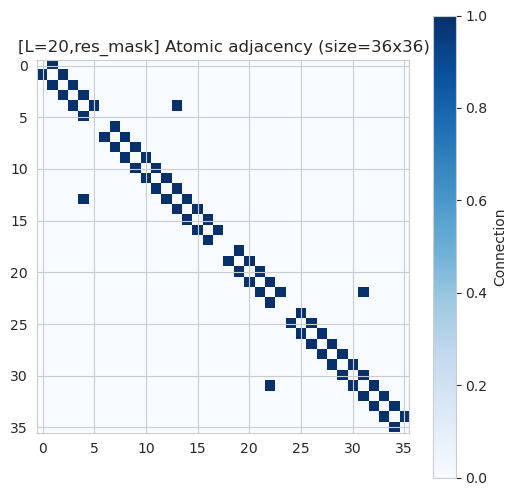

In [ ]:
# Visualize atomic adjacency for L=20 double-chain case with res_mask
import matplotlib.pyplot as plt
import numpy as np

atom_adj_20_masked_np = atom_adj_20_masked.cpu().numpy()
L_atom_20_masked = atom_adj_20_masked_np.shape[0]
print("[L=20,res_mask] atom_adj_20_masked shape:", atom_adj_20_masked_np.shape)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(atom_adj_20_masked_np, cmap="Blues", vmin=0, vmax=1)
plt.colorbar(im, ax=ax, label="Connection")
ax.set_title(f"[L=20,res_mask] Atomic adjacency (size={L_atom_20_masked}x{L_atom_20_masked})")
plt.show()